## Отладочные данные

In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [52]:
# сброс настроек

EPS = 1e-4

a1 = 0.0134
b1 = 1
c1 = 4.35e-4
m1 = 1

a2 = 2.049
b2 = 0.563e-3
c2 = 0.528e5
m2 = 1

alpha0 = 0.05
alphaN = 0.01

R = 0.5  # см
l = 10  # см
T0 = 300
t_max = 60  # с
F_max = 50  # Вт/см2

d = 0.01 * l / (-0.04)
c = -0.05 * d

k0 = 0.1  # см-1

is_4_task = False
is_f0_const = True

In [18]:
def c_fun(T):
    """коэффициент теплоемкости, Дж/см3 К"""
    return a2 + b2 * (T ** m2) - c2 / (T ** 2)


def lambda_fun(T):
    """коэффициент теплопроводности, Вт/см К"""
    return a1 * (b1 + c1 * (T ** m1))


def alpha(x):
    return c / (x - d)


def p_fun(x):
    return 2 / R * alpha(x)


def kappa(T1, T2):
    return (lambda_fun(T1) + lambda_fun(T2)) / 2


def k_fun(T):
    return k0 * ((T / 300) ** 2)


def F0(t):
    if is_f0_const:
        return 10

    if is_4_task:    
        h_ = t_max * 3.5
    
        if t < h_:
            return (F_max / t_max) * t * np.exp(-((t / t_max) - 1))
        
        coef = t // h_
        t = t - h_ * coef
        return (F_max / t_max) * t * np.exp(-((t / t_max) - 1))
    
    return F_max / t_max * t * np.exp(-(t / t_max - 1))


def f_fun(x, t, T):
    """t = time, T = Temperature"""
    return k_fun(T) * F0(t) * np.exp(-k_fun(T) * x) + 2 * T0 / R * alpha(x)

## Правая прогонка

In [19]:
def left_boundary_condition(cur_time, temp_prev, temp, tau, x0, h):
    kappa_half = kappa(temp[0], temp[1])
    c_half = (c_fun(temp[0]) + c_fun(temp[1])) / 2
    # c_half = c_fun((temp[0] + temp[1]) / 2)
    p_half = (p_fun(x0) + p_fun(x0 + h)) / 2
    # p_half = p_fun(x0 + h / 2)
    f_half = (f_fun(x0, cur_time, temp[0]) + f_fun(x0, cur_time, temp[1])) / 2
    # f_half = f_fun(x0, cur_time, (temp[0] + temp[1]) / 2)
    f_0 = f_fun(x0, cur_time, temp[0])
    
    k0 = (h/8) * c_half + (h/4) * c_fun(temp[0]) + (tau/h) * kappa_half + (h*tau/8) * p_half + (h*tau/4) * p_fun(x0) + alpha0 * tau
    m0 = (h/8) * c_half - (tau/h) * kappa_half + (h*tau/8) * p_half
    p0 = (h/8) * c_half * (temp_prev[0] + temp_prev[1]) + (h/4) * c_fun(temp[0]) * temp_prev[0] + \
         tau * alpha0 * T0 + (h*tau/4) * (f_0 + f_half)
    
    return k0, m0, p0

def right_boundary_condition(cur_time, temp_prev, temp_hat, tau, xN, h):
    kappa_half = kappa(temp_hat[-1], temp_hat[-2])
    c_half = (c_fun(temp_hat[-1]) + c_fun(temp_hat[-2])) / 2
    # c_half = c_fun((temp_hat[-2] + temp_hat[-1]) / 2)
    p_half = (p_fun(xN) + p_fun(xN - h)) / 2
    # p_half = p_fun(xN - h / 2)
    f_half = (f_fun(xN, cur_time, temp_hat[-1]) + f_fun(xN, cur_time, temp_hat[-2])) / 2
    # f_half = f_fun(xN, cur_time, (temp_hat[-2] + temp_hat[-1]) / 2)
    f_N = f_fun(xN, cur_time, temp_hat[0])
    
    kN = (h/8) * c_half - (tau/h) * kappa_half + (tau*h/8) * p_half
    mN = (h/8) * c_half + (tau/h) * kappa_half + (tau*h/8) * p_half + (h/4) * c_fun(temp_hat[-1]) + \
         (h*tau/4) * p_fun(temp_hat[-1]) + tau * alphaN
    pN = (h/8) * c_half * (temp_prev[-1] + temp_prev[-2]) + (h/4) * c_fun(temp_hat[-1]) * temp_prev[-1] + \
         tau * alphaN * T0 + (h*tau/4) * (f_N + f_half)
    
    return kN, mN, pN

def right_sweep(cur_time, temp_prev, temp, tau, x0, xN, h):
    k0, m0, p0 = left_boundary_condition(cur_time, temp_prev, temp, tau, x0, h)
    kN, mN, pN = right_boundary_condition(cur_time, temp_prev, temp, tau, xN, h)
    
    ksi = [0, -m0 / k0]
    eta = [0, p0 / k0]
    x = h
    n = 1
    
    for i in range(1, len(temp) - 1):
        aN = (tau/h) * kappa(temp[i - 1], temp[i])
        dN = (tau/h) * kappa(temp[i], temp[i + 1])
        bN = aN + dN + (h*tau) * p_fun(x) + h * c_fun(temp[i])
        fN = h * c_fun(temp[i]) * temp_prev[i] + (h*tau) * f_fun(x, cur_time, temp[i])
        
        ksi.append(dN / (bN - aN * ksi[n]))
        eta.append((aN * eta[n] + fN) / (bN - aN * ksi[n]))
        
        n += 1
        x += h
        
    y = [0] * (n + 1)
    y[n] = (pN - kN * eta[n]) / (kN * ksi[n] + mN)
    
    for i in range(n - 1, -1, -1):
        y[i] = ksi[i + 1] * y[i + 1] + eta[i + 1] 
    
    return y

## Метод простых итераций

In [20]:
def layer_iteration(cur_time, start_temp, tau, x0, xN, h):
    prev_temp = start_temp
    temp = start_temp
    
    while True:
        next_temp = right_sweep(cur_time, prev_temp, temp, tau, x0, xN, h)
        count = 0
        
        for i in range(len(prev_temp)):
            if abs((temp[i] - next_temp[i]) / next_temp[i]) < EPS:
                count += 1
            
        if count == len(prev_temp):
            break
            
        temp = next_temp
    
    return next_temp

def iterations(time0, timeM, tau, x0, xN, h):
    n = int((xN - x0) / h)
    start_temp = [T0 for _ in range(n + 1)]
    x = np.arange(x0, xN + h, h)
    times = np.arange(time0, timeM + tau, tau)
    res_temp = []
    
    prev_temp = start_temp
    
    for cur_time in times:
        cur_temp = layer_iteration(cur_time, prev_temp, tau, x0, xN, h)
        res_temp.append(cur_temp)
        prev_temp = cur_temp
        
    return np.array(x), np.array(times), np.array(res_temp)

## Задание №1

шаг по x: h = 0.03333333333333333
шаг по времени: tau = 3.0


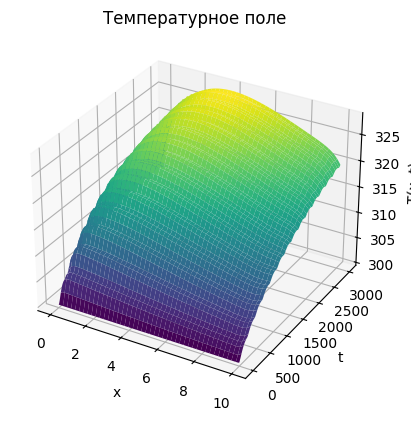

In [50]:
a = 0
b = l
N = 300
h = (b - a) / N

_a2=a2
a2=100
__t_max = t_max
t_max = 60

t0 = 0
tM = 3000
M = 1000
tau = (tM - t0) / M

print(f"шаг по x: h = {h}\nшаг по времени: tau = {tau}")
is_4_task = True
x, times, temp = iterations(t0, tM, tau, a, b, h)
X, T = np.meshgrid(x, times)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, temp, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('T(x, t)')
ax.set_title('Температурное поле')
plt.show()
is_4_task = False
a2=_a2
t_max = __t_max

In [22]:
#%matplotlib notebook
plt.close()

## Задание №2

In [23]:
def nice_h(_t0, _tM, _tau, _x0, _xN):
    cur_h = 0.2
    print("h", end="")
    
    while True:
        h1 = cur_h
        x_1, times_1, res_temp_1 = iterations(_t0, _tM, _tau, _x0, _xN, h1)
        fixed_temp_1 = dict(zip(x_1, res_temp_1[len(times_1) // 2]))
        
        h2 = cur_h / 2
        x_2, times_2, res_temp_2 = iterations(_t0, _tM, _tau, _x0, _xN, h2)
        fixed_temp_2 = dict(zip(x_2, res_temp_2[len(times_2) // 2]))
        
        count = 0
        
        for x in fixed_temp_1.keys():
            if abs((fixed_temp_1[x] - fixed_temp_2[x]) / fixed_temp_2[x]) < EPS2:
                count += 1
                
        if count == len(x_1):
            break
            
        cur_h /= 2
        print(".", end="")
    
    print("")
    
    return cur_h

def nice_tau(_t0, _tM, _h, _x0, _xN):
    cur_tau = 5
    print("t", end="")
    
    while True:
        tau1 = cur_tau
        x_1, times_1, res_temp_1 = iterations(_t0, _tM, tau1, _x0, _xN, _h)
        res = []
        for row in res_temp_1:
            res.append(row[len(x_1) // 2])
        
        fixed_temp_1 = dict(zip(times_1, res))
        
        tau2 = cur_tau / 2
        x_2, times_2, res_temp_2 = iterations(_t0, _tM, tau2, _x0, _xN, _h)
        res = []
        for row in res_temp_2:
            res.append(row[len(x_2) // 2])
        fixed_temp_2 = dict(zip(times_2, res))
        
        count = 0
        
        for x in fixed_temp_1.keys():
            if abs((fixed_temp_1[x] - fixed_temp_2[x]) / fixed_temp_2[x]) < EPS2:
                count += 1
                
        if count == len(times_1):
            break
            
        cur_tau /= 2
        print(".", end="")
    
    print("")
    
    return cur_tau

In [24]:
EPS2 = 1e-4
a = 0
b = l
N = 200
h = (b - a) / N

t0 = 0
tM = 60
M = 100
tau = (tM - t0) / M

print(f"шаг по x: h = {h}\nшаг по времени: tau = {tau}")

шаг по x: h = 0.05
шаг по времени: tau = 0.6


In [25]:
_h = nice_h(t0, tM, tau, a, b)
_tau = nice_tau(t0, tM, _h, a, b)

print(f"Оптимальный шаг по x: h = {_h}")
print(f"Оптимальный шаг по t: tau = {_tau}")

h........
t..
Оптимальный шаг по x: h = 0.00078125
Оптимальный шаг по t: tau = 1.25


........................................................................................................................................................................................................................................................................................

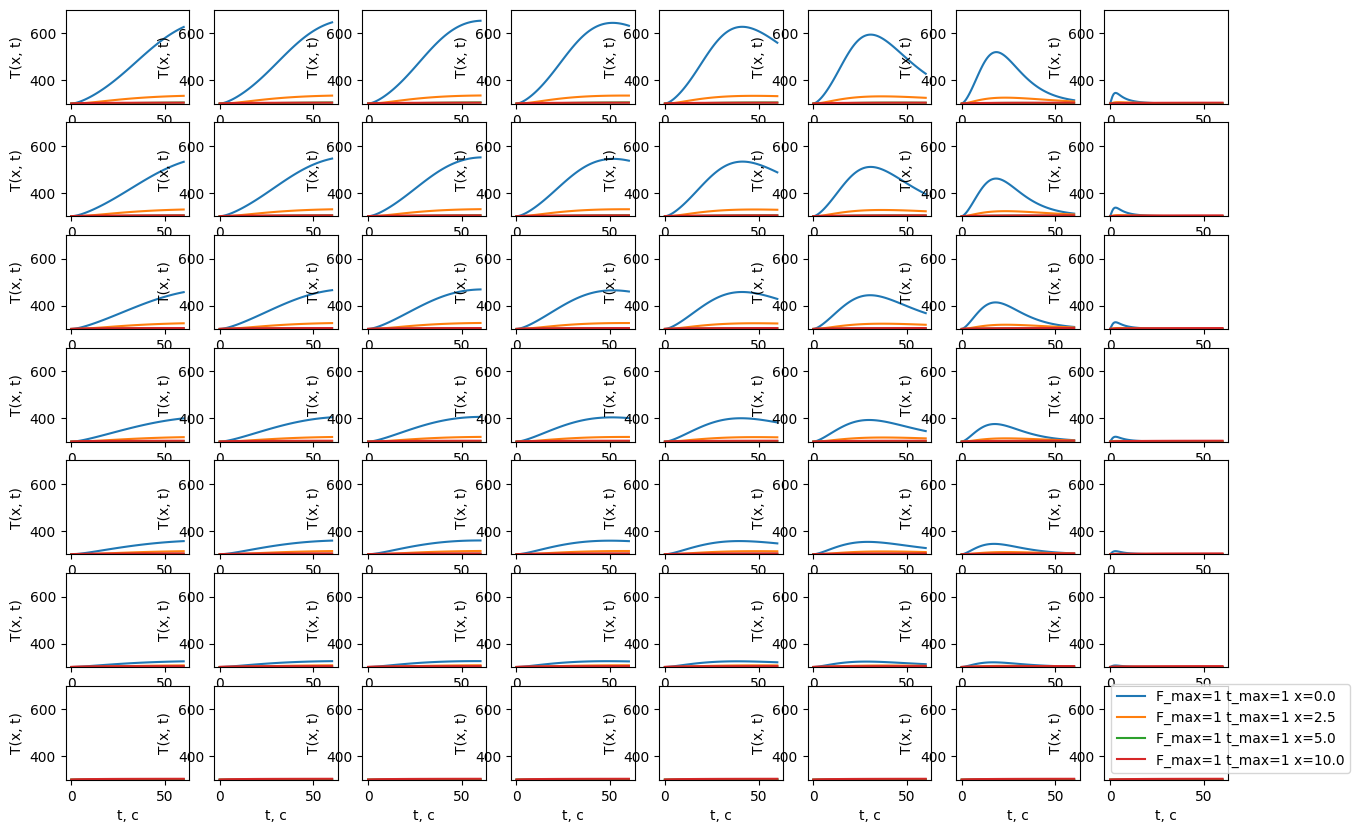

In [26]:
F_max_list = [60, 50, 40, 30, 20, 10, 1]
t_max_list = [70, 60, 50, 40, 30, 20, 10, 1]

plt.figure(figsize=(15,10))

for i, _F_max in enumerate(F_max_list):
    for j, _t_max in enumerate(t_max_list):
        plt.subplot(len(F_max_list), len(t_max_list), i * len(t_max_list) + j + 1)
        F_max = _F_max
        t_max = _t_max
        x, times, temp = iterations(t0, tM, tau, a, b, h)
        
        index_x = [0, len(temp[0]) // 4, len(temp[0]) // 2, len(temp[0]) - 1]
        for ind_x in index_x:
            curr_temp = [t[ind_x] for t in temp]
            plt.xlabel("t, c")
            plt.ylabel("T(x, t)")
            plt.ylim((300, 700))
            plt.grid()
            plt.plot(times, curr_temp, label=f"F_max={_F_max} t_max={_t_max} x={x[ind_x]}")
            print(".", end="")
        print(".", end="")
plt.legend()
        
plt.show()

.............................................

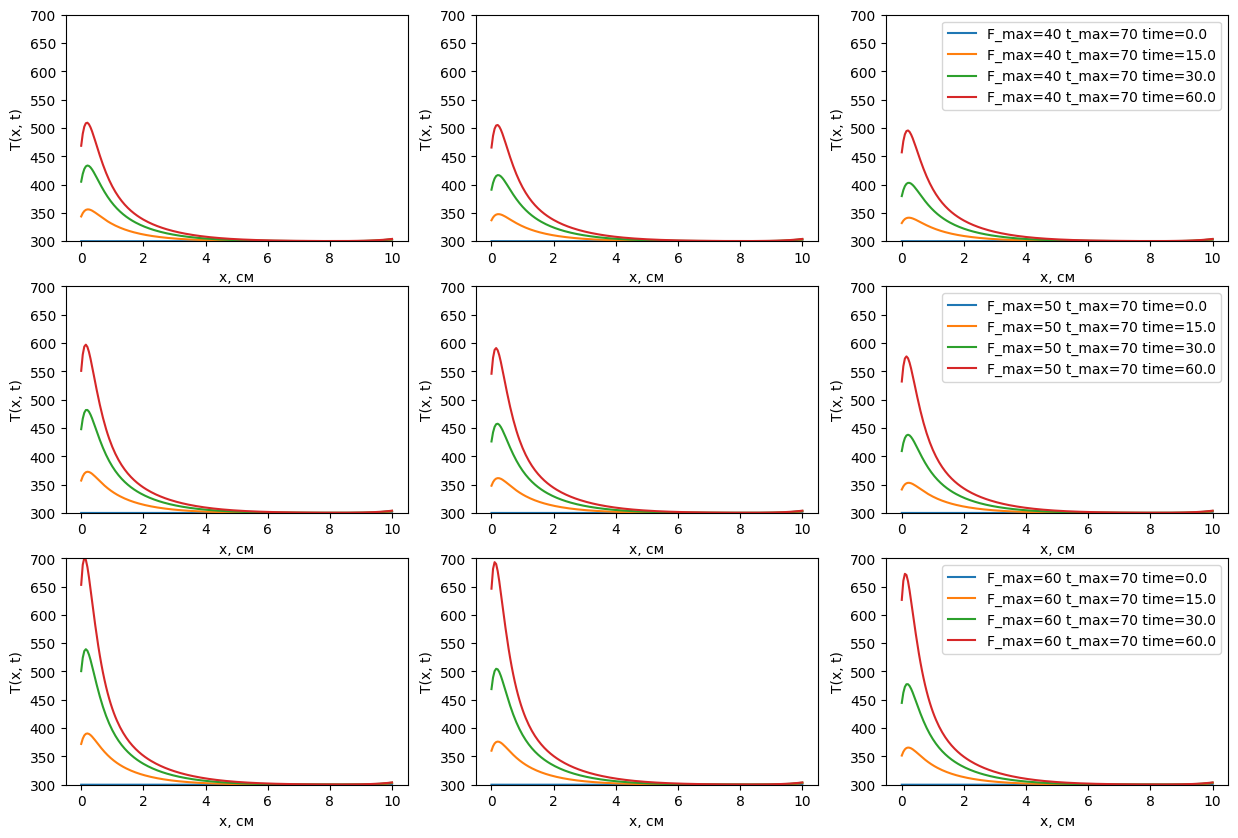

In [27]:
F_max_list = [40, 50, 60]
t_max_list = [50, 60, 70]

plt.figure(figsize=(15,10))

for i, _F_max in enumerate(F_max_list):
    for j, _t_max in enumerate(t_max_list):
        plt.subplot(len(F_max_list), len(t_max_list), i * len(t_max_list) + j + 1)
        F_max = _F_max
        t_max = _t_max
        x, times, temp = iterations(t0, tM, tau, a, b, h)
        
        index_t = [0, len(temp) // 4, len(temp) // 2, len(temp) - 1]
        for ind_t in index_t:
            curr_temp = temp[ind_t]
            plt.xlabel("x, см")
            plt.ylabel("T(x, t)")
            plt.ylim((300, 700))
            plt.grid()
            plt.plot(x, curr_temp, label=f"F_max={_F_max} t_max={_t_max} time={times[ind_t]}")
            print(".", end="")
        print(".", end="")
    plt.legend()
        
plt.show()

In [28]:
table_size = 101
# file = open("../data/optimal_steps.txt", "w", encoding="utf-8")

print("-" * table_size)
print(f'| {"F_max": ^22} | {"t_max": ^22} | {"h": ^22} | {"tau": ^22} |')
print("-" * table_size)

f_max_list = [60, 50, 40, 30, 20, 10, 1]
t_max_list = [70, 60, 50, 40, 30, 20, 10, 1]

for _f_max in f_max_list:
    for _t_max in t_max_list:
        F_max = _f_max
        t_max = _t_max

        new_h = nice_h(t0, tM, tau, a, b)
        new_tau = nice_tau(t0, tM, h, a, b)

        print(f'| {_f_max: ^22} | {_t_max: ^22} | {new_h: ^22} | {new_tau: ^22} |')

print("-" * table_size)

-----------------------------------------------------------------------------------------------------
|         F_max          |         t_max          |           h            |          tau           |
-----------------------------------------------------------------------------------------------------
h......

KeyboardInterrupt: 

In [29]:
def check_optimal(_t0, _tM, _tau, _x0, _xN, _h):
    x, times, temp = iterations(_t0, _tM, _tau, _x0, _xN, _h)
    i_t = -1
    EPS3 = 1e-2
    
    left = 0
    for i in range(0, len(x) - 1):
        f_i =   alpha(x[i]) * (temp[i_t][i] - T0)
        f_i_1 = alpha(x[i+1]) * (temp[i_t][i] - T0)
        left += _h * (f_i + f_i_1) / 2
    
    right = 0
    for i in range(0, len(x) - 1):
        f_i =   k_fun(temp[i_t][i]) * np.exp(-k_fun(temp[i_t][i]) * x[i])
        f_i_1 = k_fun(temp[i_t][i+1]) * np.exp(-k_fun(temp[i_t][i+1]) * x[i+1])
        right += _h * (f_i + f_i_1) / 2
        
    f0 = -alpha(x[0]) * (temp[i_t][0] - T0)
    fN =  alpha(x[-1]) * (temp[i_t][-1] - T0)
    
    acc = abs((-f0 + fN + 2/R * left) / (F0(times[-1]) * right) - 1)
    print(acc)
    
    if acc <= EPS3:
        print("ok")
    else:
        print("not ok")

In [30]:
is_f0_const = True
check_optimal(t0, tM, _tau, a, b, _h)
is_f0_const = False
# check_optimal(t0, tM, 1.25, a, b, 0.0055)

0.008873440638994201
ok


## Задание №3

In [31]:
a = 0
b = l
N = 200
h = (b - a) / N

t0 = 0
tM = 500
M = 200
tau = (tM - t0) / M

print(f"шаг по x: h = {h}\nшаг по времени: tau = {tau}")

шаг по x: h = 0.05
шаг по времени: tau = 2.5


...............

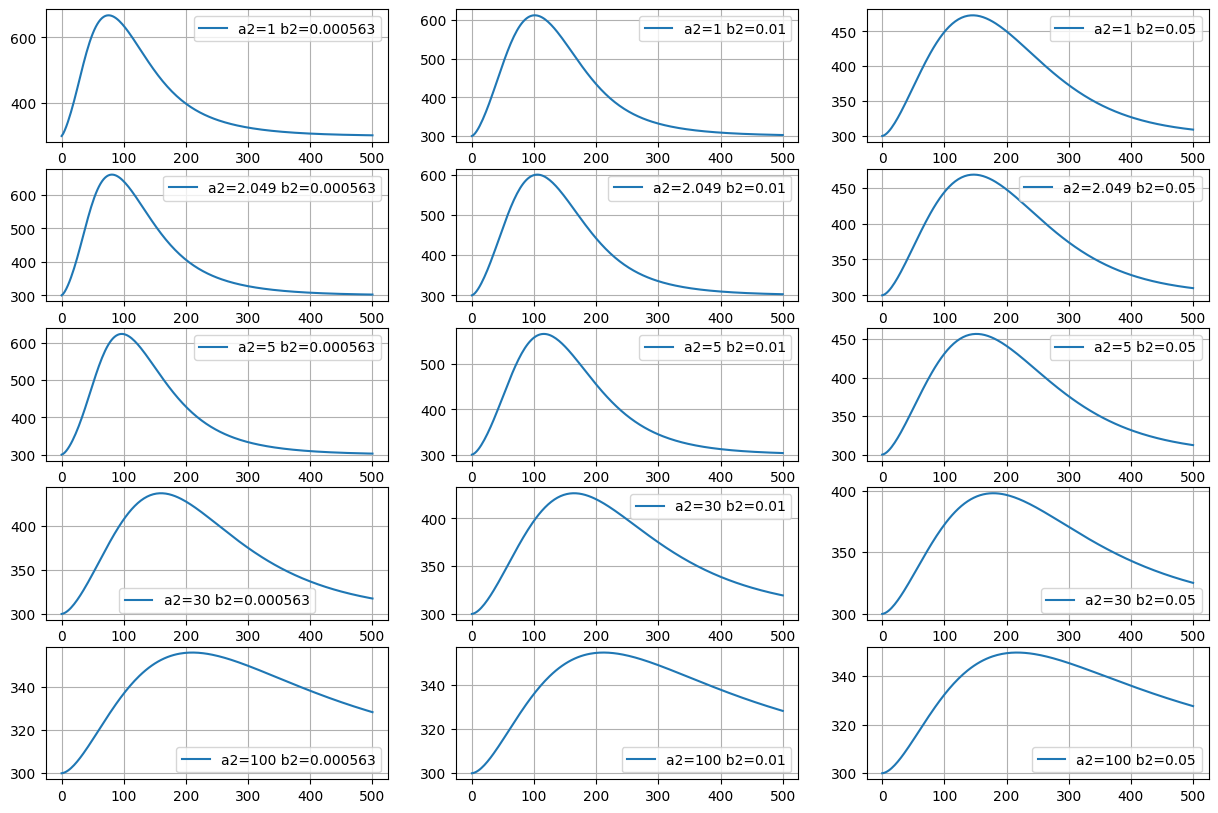

In [32]:
old_a2 = a2
old_b2 = b2

a2_list = [1, 2.049, 5, 30, 100]
b2_list = [0.563e-3, 1e-2, 5e-2]

plt.figure(figsize=(15, 10))

for i, _a2 in enumerate(a2_list):
    for j, _b2 in enumerate(b2_list):
        plt.subplot(len(a2_list), len(b2_list), i * len(b2_list) + j + 1)

        a2 = _a2
        b2 = _b2
        x, times, temp = iterations(t0, tM, tau, a, b, h)

        temp_0 = [t[0] for t in temp]

        plt.plot(times, temp_0, label=f"a2={a2} b2={b2}")
        plt.grid()
        plt.legend()

        print(".", end="")
        
a2, b2 = old_a2, old_b2

## Задание №4

In [33]:
a = 0
b = l
N = 400
h = (b - a) / N

t0 = 0
tM = 2000
M = 1500
tau = (tM - t0) / M

print(f"шаг по x: h = {h}\nшаг по времени: tau = {tau}")

шаг по x: h = 0.025
шаг по времени: tau = 1.3333333333333333


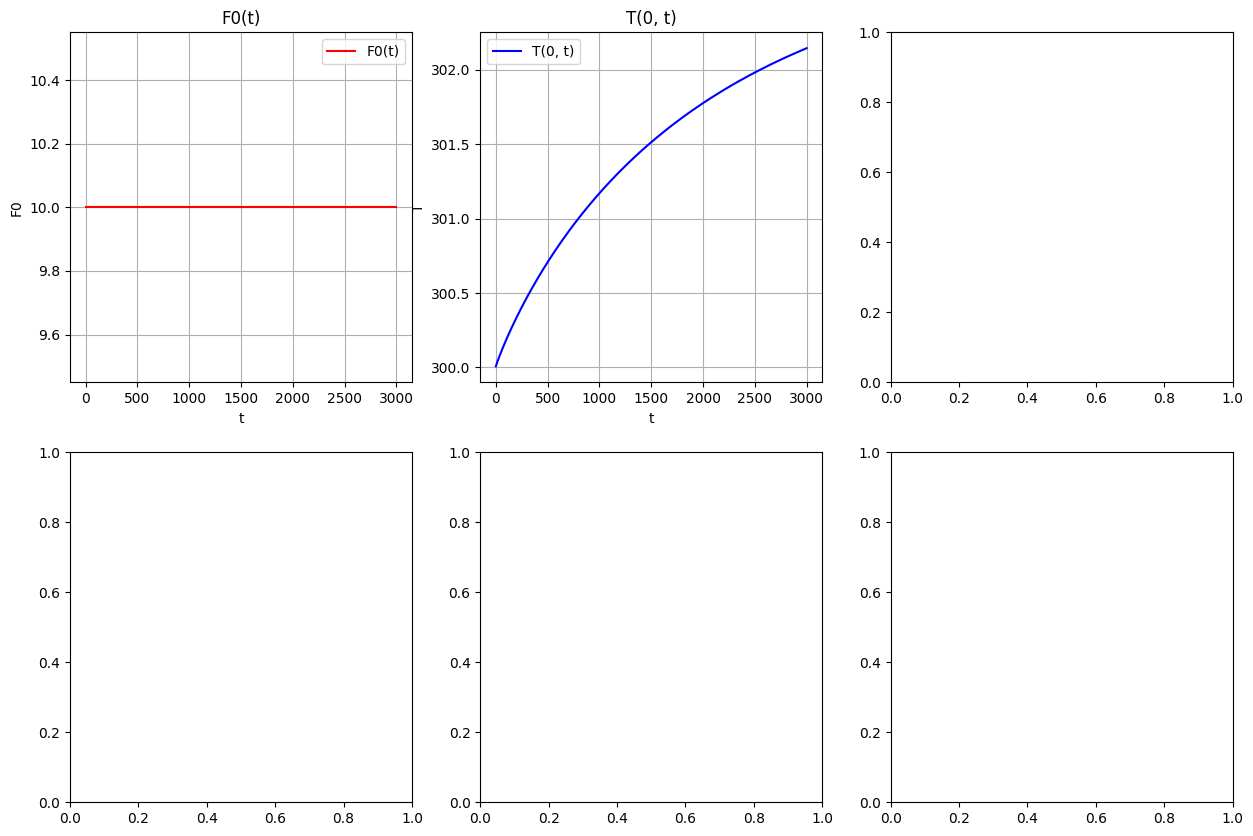

In [54]:
# is_4_task = True
_a2 = a2
__t_max = t_max
__F_max = F_max
_b2 = b2
_a1 = a1
t_max = 20
F_max = 50
a2 = 500.49
b2 = 2e-2
# a1 = 100

fig2, axes = plt.subplots(2, 3, figsize=(15, 10))

t_f0 = np.arange(t0, tM + tau, tau)

res = []
for curr_t in t_f0:
    res.append(F0(curr_t))
    
axes[0, 0].plot(t_f0, res, 'r', label="F0(t)")
axes[0, 0].set_title('F0(t)')
axes[0, 0].set_xlabel('t')
axes[0, 0].set_ylabel('F0')
axes[0, 0].legend()
axes[0, 0].grid()

x, times, temp = iterations(t0, tM, tau, a, b, h)

res = []
for t_m in temp:
    res.append(t_m[0])
    
axes[0, 1].plot(times, res, 'b', label=f"T(0, t)")
axes[0, 1].set_title('T(0, t)')
axes[0, 1].set_xlabel('t')
axes[0, 1].set_ylabel('T')
axes[0, 1].legend()
axes[0, 1].grid()
    
plt.show()
is_4_task = False
a2 = _a2
t_max = __t_max
F_max = __F_max
b2 = _b2
a1 = _a1